In [1]:
#import important libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# import libraries for EDA and preprocessing
from datetime import datetime
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

# Train test split
from sklearn.model_selection import train_test_split

# Text pre-processing
import tensorflow as tf
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# Modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional

# Evaluating
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report,confusion_matrix

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Step 1: Brief description of the problem and data 

### 1.1 Problem

Twitter is one of social media that has become an important communication channel in different situations, for instance, in times of emergency. The smartphones enable people to announce an emergency they see in real-time. Because of that, there is an challenge that how to recognize whether a tweet text is talking about a real disaster or uses those keywords as a metaphor, which can lead to huge mislabeling of tweets. Hence, this project aims
on using Natural Language Processing (NLP) and classification models to distinguish between real and fake disaster tweets.  

To do this, first, we will inspect, visualize, clean and vectorize the data then split train data into train_df (85%) and valid_df (15%) and train three models:  

(1) Long Short Term Memory (LSTM)  
(2) Bidirectional Long Short Term Memory (Bi-LSTM) 
(3) Gated Recurrent Unit (GRU)

Then, I will compare these three deep learning models by validation accuracy score and tune hyperparmeter (dropout) to get the best model and use this best model for predicting test data and print out the submission file.

Reference Source:   
(1) https://www.kaggle.com/code/philculliton/nlp-getting-started-tutorial/notebook  
(2) https://medium.com/mlearning-ai/the-classification-of-text-messages-using-lstm-bi-lstm-and-gru-f79b207f90ad  


### 1.2 Data

In this project, I use data from Kaggle, were downloaded from the link:     
https://www.kaggle.com/competitions/nlp-getting-started/data

There are two data from this resource, included train and test data. Train data has 7613 observations and 5 columns included : id, keyword, location, text and target. Test data has 3263 observations and 4 columns included: id, keyword, location and text.

In [2]:
# read train data
df = pd.read_csv('../input/nlp-getting-started/train.csv')
#df = pd.read_csv('train.csv')

# take a look at some rows of train data
df.head()


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
# read test data
test = pd.read_csv('../input/nlp-getting-started/test.csv')
#test = pd.read_csv('test.csv')

# take a look at some rows of test data
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [4]:
# view some rows of the sample submisson
sample_submission = pd.read_csv('../input/nlp-getting-started/sample_submission.csv')
#sample_submission = pd.read_csv('sample_submission.csv')
sample_submission.head()


,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [5]:
# the shape of train data
df.shape


(7613, 5)

In [6]:
# the shape of test data
test.shape


(3263, 4)

## Step 2: Exploratory Data Analysis (EDA) - Inspect, Visualize, and Clean the Data

### 3.1 Inspect the data

In [7]:
# look at the first example of a not disaster tweet
fake_disaster_tweet = df[df["target"] == 0]
fake_disaster_tweet["text"].values[0]


"What's up man?"

In [8]:
# look at the first example of a disaster tweet
real_disaster_tweet = df[df["target"] == 1]
real_disaster_tweet["text"].values[0]


'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [9]:
# get a quick description of the data
df.describe()


,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [10]:
# check null values in data
df.isnull().sum()


id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [11]:
# check for duplicate articles
df.duplicated(keep=False).sum()


0

In [12]:
# the structure of data also tells us the number of rows (observations) and columns (variables)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [13]:
# get the label of data
df['target'].unique()


array([1, 0])

In [14]:
# the structure of data also tells us the number of rows (observations) and columns (variables)
test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [15]:
# check null values in test data
test.isnull().sum()


id             0
keyword       26
location    1105
text           0
dtype: int64

In [16]:
# check for duplicate observations in test data
test.duplicated(keep=False).sum()


0

From the output above, we can summarize that:  
+ There are 7613 observations and 5 columns in train data. 
+ There is no missing values in "id", "text" and "target" column in train data.
+ There is no missing values in "id" and "text" column in test data.
+ There is no duplicated observations in both train and test data.  
+ There are 2 targets: 0 (fake disaster tweet) and 1 (real disaster tweet).

  

### 3.2 Visualize the data

Next, let's calculate and visualize the count and the proportion of each target.


In [17]:
# calculate the count of each target
df['target'].value_counts()


0    4342
1    3271
Name: target, dtype: int64

In [18]:
# calculate the proportion of each label
df['target'].value_counts()/len(df)*100


0    57.034021
1    42.965979
Name: target, dtype: float64

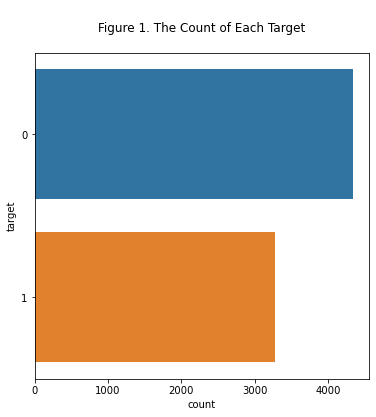

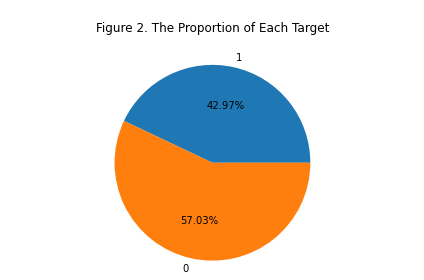

In [19]:
# plot the count of each label
fig, ax = plt.subplots(figsize=(6,6))
sns.countplot(data=df, y='target', ax=ax).set(title='\nFigure 1. The Count of Each Target\n')

# plot the proportion of each category
labels = df['target'].unique().tolist()
counts = df['target'].value_counts()
sizes = [counts[v] for v in labels]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%0.2f%%')
ax1.axis('equal')
plt.title("\nFigure 2. The Proportion of Each Target\n")
plt.tight_layout()
plt.show()


Figure 1 shows the count of each label and figure 2 shows the proportions of each target. Looking at these two figures, we can see that in overall, the number of observations for "1" target is larger than the number of observations for "0" target. So, to solve this problem, I will balance the data by downsampling the fake disaster tweets before build models since if one or two categories was severely underrepresentated or, in contrast, overrepresentative in the train data, then it may cause our model to be biased and/or perform poorly on some or all of the test data.

### 3.3 Clean the data/ Data Preprocessing

#### 3.3.1 Clean the data

To clean the data for training models, some works has to be done such as:  
+ balance the data by downsampling the fake disaster tweets
+ drop unused columns in train data included: id, keyword and location.   

To preprocess our text simply means to bring our text into a form that is predictable and analyzable for our task. So, what I am going to do is:   

(1) lowercasing all our text data    
(2) remove punctuation    
(3) remove stop words: stop words are a set of commonly used words in a language. Examples of stop words in English are “a”, “the”, “is”, “are” and etc. The intuition behind using stop words is that, by removing low information words from text, we can focus on the important words instead.  
(4) lemmatization: lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma. For example, runs, running, ran are all forms of the word run, therefore run is the lemma of all these words.
    
Since I'm planning to redo these cleaning steps for a test data without target as well, thus for convenience, I will create a clean_text function for this data and reuse it for cleaning untargeted test data later.


In [20]:
# downsample the fake disater tweet
fake_disaster = fake_disaster_tweet.sample(n = len(real_disaster_tweet), random_state = 44)
df_news = pd.concat([fake_disaster, real_disaster_tweet], axis=0).reset_index(drop=True)
df_news["target"].value_counts()


0    3271
1    3271
Name: target, dtype: int64

In [21]:
# drop id, keyword and location columns
df_news = df_news.loc[:, ["text", "target"]]

# view some sample rows of df_news
df_news.sample(10)

,text,target
284,Detonation fashionable mountaineering electron...,0
6291,#Earthquake #Sismo M 1.9 - 5km S of Volcano Ha...,1
6190,Trauma injuries involving kids and sport usual...,1
1,@DyannBridges @yeshayad Check out this #rockin...,0
2135,@Eric_Tsunami worry about yourself,0
966,collapsed the moment i got home last night lol,0
3522,#anthrax #bioterrorism CDC To Carry Out Extens...,1
2138,I liked a @YouTube video http://t.co/FNpDJwVw1...,0
1479,someone's gonna get screamed at for getting th...,0
6490,Related News: \n\nPlane Wreckage Found Is Part...,1


In [22]:
def clean_text(data, text):
    # lowercasing all text data
    data[text] = data[text].str.lower()
    # remove punctuation
    data[text] = data[text].str.replace('[^\w\s]', '', regex=True)
    # remove stop words
    stop_words = stopwords.words('english')
    data[text] = data[text].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
    # lemmatization
    lemmatizer = WordNetLemmatizer()
    data[text] = data[text].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
    return


In [23]:
# clean news data
clean_text(df_news, "text")

# view text in a row after cleaning all text data
df_news["text"][1]


'dyannbridges yeshayad check rockin preview claytonbryant danger zone coming soon httpstcoipgmf4ttdx artistsunited'

In [24]:
# calculate the count of word per observation
df_news["Word_Count"] = df_news['text'].apply(lambda x: len(x.split()))


In [25]:
# view some first rows of news data
df_news.head()


,text,target,Word_Count
0,bcfcticketlady mr_aamir_javaid see inundated a...,0,12
1,dyannbridges yeshayad check rockin preview cla...,0,12
2,hot funtenna hijacking computer send data soun...,0,14
3,nasasolarsystem jupiter great red spot violent...,0,12
4,learn gained access secret top earner amp used...,0,14


In [26]:
# The average count of word per observation
print("The average count of word per observation", round(np.mean(df_news.Word_Count)))

# The maximum count of word per observation
print("The maximum count of word per observation", round(np.max(df_news.Word_Count)))

# The minimum count of word per observation
print("The minimum count of word per observation", round(np.min(df_news.Word_Count)))


The average count of word per observation 10
The maximum count of word per observation 25
The minimum count of word per observation 1


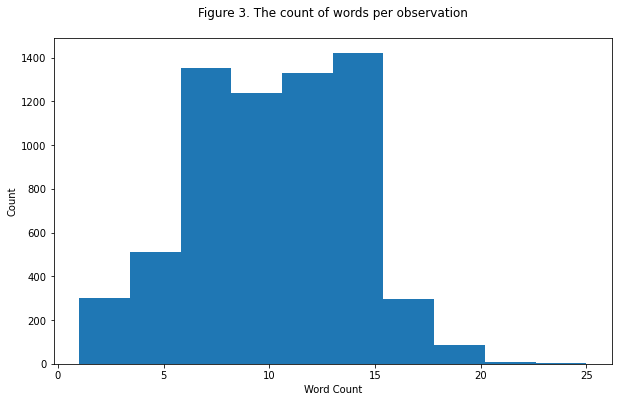

In [27]:
# plot the count of word per observation
fig, ax = plt.subplots(figsize=(10,6))
df_news['Word_Count'].plot(kind='hist')
plt.xlabel("Word Count")
plt.xticks(rotation=360)
plt.ylabel("Count")
plt.title("Figure 3. The count of words per observation\n")
plt.show()


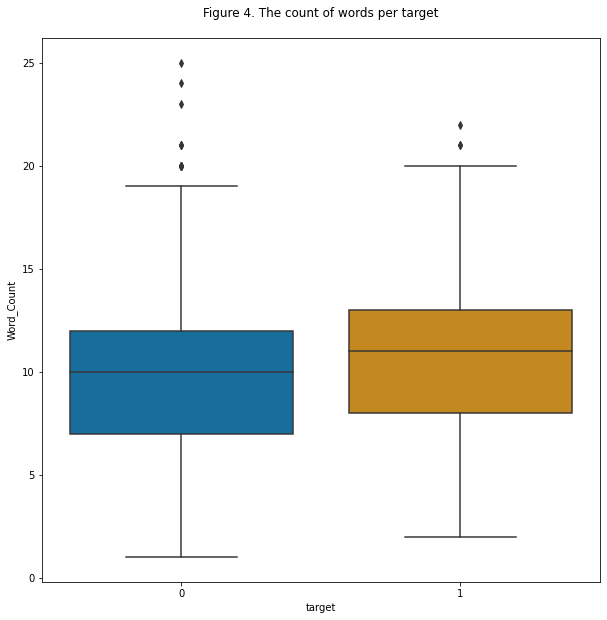

In [28]:
# visualize the count of words per label
fig, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(data = df_news, x = 'target', y = 'Word_Count', palette = 'colorblind'
           ).set(title = 'Figure 4. The count of words per target\n')
plt.show()


Looking at figure 4, we observe that the mean and the variability of word count of fake and real disaster tweets are not different much.

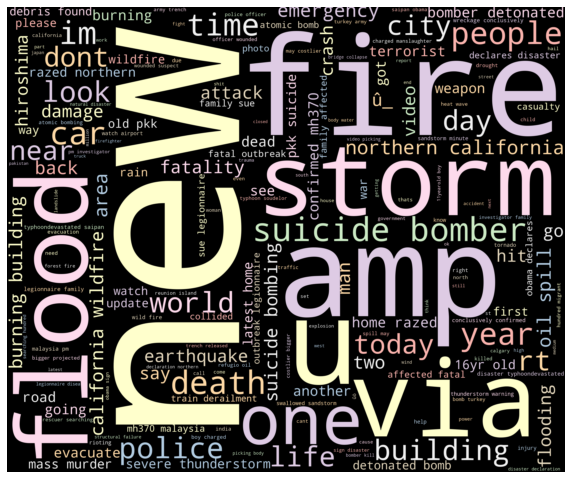

In [29]:
# Generate a word cloud image for real disaster tweets
real_disaster_text = ' '.join(df_news[df_news["target"] == 1]["text"])
real_disaster_text_cloud = WordCloud(width =3000,
                          height =2500,
                          stopwords=STOPWORDS,
                          background_color ="black",
                          colormap='Pastel1').generate(real_disaster_text)
plt.figure(figsize=(10,10))
plt.imshow(real_disaster_text_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

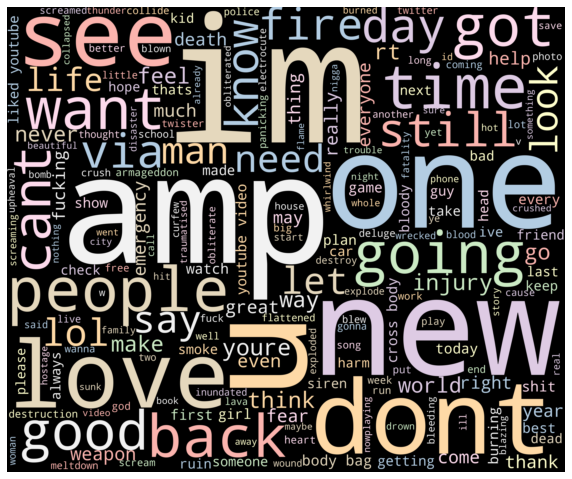

In [30]:
# Generate a word cloud image for fake disaster tweets
fake_disaster_text = ' '.join(df_news[df_news["target"] == 0]["text"])
fake_disaster_text_cloud = WordCloud(width =3000,
                          height =2500,
                          stopwords=STOPWORDS,
                          background_color ="black",
                          colormap='Pastel1').generate(fake_disaster_text)
plt.figure(figsize=(10,10))
plt.imshow(fake_disaster_text_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()


#### 3.3.2 Data Preprocessing

Text data requires a special approach to machine learning. This is because text data can have hundreds of thousands of dimensions (words and phrases) but tends to be very sparse. Machines, unlike humans, cannot understand the raw text. Machines can only see numbers. Particularly, statistical techniques such as machine learning can only deal with numbers. Therefore, we need to convert the text data into numerical representation, so the model will understand it.

Different approaches exist to convert text into the corresponding numerical form. In this case I will use Count Vectorizer to transform a given text into a vector on the basis of the frequency (count) of each word that occurs in the entire text. I choose this method because:

1. It is one of the simplest ways of doing text vectorization.

2. It creates a document term matrix, which is a set of dummy variables that indicates if a particular word appears in the document.

3. Count vectorizer will fit and learn the word vocabulary and try to create a document term matrix in which the individual cells denote the frequency of that word in a particular document, which is also known as term frequency, and the columns are dedicated to each word in the corpus.


In [31]:
# drop word_count column 
df_news = df_news.drop(columns='Word_Count')


In [32]:
X = df_news["text"]
Y = df_news["target"]

In [33]:
count_vectorizer = feature_extraction.text.CountVectorizer()

## let's get counts for the first 5 tweets in the data
example_train_vectors = count_vectorizer.fit_transform(X[0:5])

In [34]:
## we use .todense() here because these vectors are "sparse" (only non-zero elements are kept to save space)
print(example_train_vectors[0].todense().shape)
print(example_train_vectors[0].todense())

(1, 64)
[[0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1
  0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0]]


This example shows us that: 
+ There are 42 unique words (tokens) in the first five tweets.
+ The first tweet contains only some of those unique tokens - all of the non-zero counts above are the tokens that do exist in the first tweet.

In [35]:
# create vector for train set
train_vectors = count_vectorizer.fit_transform(X)


In [36]:
# create a list to store validation accuracy score
valid_auc_score = []

#### Split data

After cleaning and vectorizing data by CountVectorizer, to prepare for building and training models, I'll split 20% of the data into validation set. Noted that, I'll use sklearn train_test_split to split the data, with default shuffle = True and stratify=target, means this method will split our data into random train and test subsets and have the same proportion of target in df_news. 


In [37]:
# shuffle and split the data into train and test set
x_train, x_valid, y_train, y_valid = train_test_split(train_vectors, Y, test_size=0.15, 
                                                      shuffle=True, 
                                                      random_state = 42,
                                                      stratify=df_news.target)

# # get shape of train and validation dataset after splitting
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)


(5560, 18980) (5560,)
(982, 18980) (982,)


In [38]:
# view train data
print('Training set:')
x_train = x_train.toarray()
x_train


Training set:


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [39]:
# view validation data
print('Validation set:')
x_valid = x_valid.toarray()
x_valid


Validation set:


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [40]:
# check target value count in train and validation set
print(y_train.value_counts())
print(y_valid.value_counts())


1    2780
0    2780
Name: target, dtype: int64
0    491
1    491
Name: target, dtype: int64


## Step 4: Building and training models

### 4.1 Long Short Term Memory (LSTM)

Long Short Term Memory (LSTM) was designed to overcome the problems of simple Recurrent Neural Network (RNN) by allowing the network to store data in a sort of memory that it can access at a later times. The key of the LSTM model is the cell state. The cell state is updated twice with few computations that resulting stabilize gradients. It has also a hidden state that acts like a short term memory.  

In LSTM there are Forget Gate, Input Gate and Output Gate.

(1) The first step is to decide what information we’re going to throw away from the cell state. This decision is made by a sigmoid layer called the “Forget Gate” layer.   
(2) The second step is to decide what new information that we’re going to store in the cell state. This has two parts. First, a sigmoid layer called the “Input Gate” layer decides which values we’ll update. Next, a tanh layer which creates a vector of new candidate values that could be added to the state.   
(3) Finally, we need to decide what we are going to output. This output will be based on our cell state, but will be a filtered version. First, we run a sigmoid layer which decides what parts of the cell state we’re going to output. Then, we put the cell state through tanh (to push the values to be between -1 and 1) and multiply it by the output of the sigmoid gate, so that we only output the parts we decided.   

We use the binary_crossentropy as a loss function because the output of the model is binary and for the optimizer, we use adam which makes use of momentum to avoid local minima.  
 
+ epoch : number of times the learning algorithm will work through the entire training data.
+ callbacks : to pass the early stopping parameter. EarlyStopping(monitor=’val_loss’, patience=2) was used to define that we want to monitor the validation loss and if the validation loss is not improved after 2 epochs, then the model training will stop. This technique helps to avoid overfitting problem.
+ verbose : 2 , it will show us loss and accuracy on each epoch.

In [41]:
# Define the LSTM model architecture

# Define parameter
n_lstm = 200
embedding_dim = 128
max_len = train_vectors.shape[1]
drop_lstm = 0.2
vocab_size = len(set(" ".join(X).split()))
print(vocab_size)


19017


In [42]:
# Define LSTM Model 
model1 = Sequential()
model1.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model1.add(SpatialDropout1D(drop_lstm))
model1.add(LSTM(n_lstm, return_sequences=False))
model1.add(Dropout(drop_lstm))
model1.add(Dense(1, activation='sigmoid'))

# summary model1
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 18980, 128)        2434176   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 18980, 128)        0         
_________________________________________________________________
lstm (LSTM)                  (None, 200)               263200    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 2,697,577
Trainable params: 2,697,577
Non-trainable params: 0
_________________________________________________________________


In [43]:
# compile the model
model1.compile(loss = 'binary_crossentropy',
               optimizer = 'adam',
               metrics = ['accuracy', tf.keras.metrics.AUC()])

In [44]:
num_epochs = 10
early_stop = EarlyStopping(monitor='val_loss', patience=2)
mp = ModelCheckpoint(filepath='model1_cp', monitor='val_loss', save_best_only=True)
history = model1.fit(x_train,
                     y_train,
                     epochs=num_epochs, 
                     validation_data=(x_valid, y_valid),
                     callbacks =[early_stop, mp],
                     verbose=2)

Epoch 1/10
174/174 - 200s - loss: 0.6943 - accuracy: 0.4950 - auc: 0.4947 - val_loss: 0.6940 - val_accuracy: 0.5000 - val_auc: 0.5000
Epoch 2/10
174/174 - 195s - loss: 0.6936 - accuracy: 0.5018 - auc: 0.5029 - val_loss: 0.6934 - val_accuracy: 0.5000 - val_auc: 0.5000
Epoch 3/10
174/174 - 195s - loss: 0.6936 - accuracy: 0.4960 - auc: 0.4931 - val_loss: 0.6934 - val_accuracy: 0.5000 - val_auc: 0.5000
Epoch 4/10
174/174 - 195s - loss: 0.6936 - accuracy: 0.4980 - auc: 0.4946 - val_loss: 0.6932 - val_accuracy: 0.5000 - val_auc: 0.5000
Epoch 5/10
174/174 - 195s - loss: 0.6934 - accuracy: 0.4980 - auc: 0.5000 - val_loss: 0.6939 - val_accuracy: 0.5000 - val_auc: 0.5010
Epoch 6/10
174/174 - 195s - loss: 0.6933 - accuracy: 0.5031 - auc: 0.5051 - val_loss: 0.6934 - val_accuracy: 0.5000 - val_auc: 0.5000


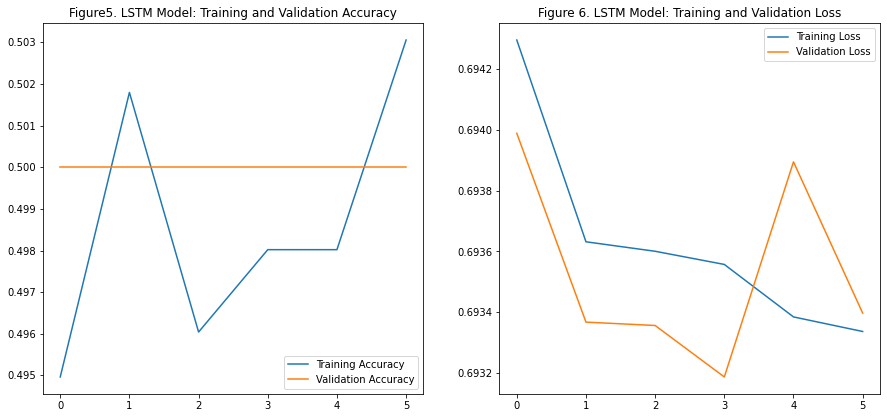

In [45]:
# plot the graph of accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(6)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Figure5. LSTM Model: Training and Validation Accuracy')

# plot the graph of loss
plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Figure 6. LSTM Model: Training and Validation Loss')
plt.show()

### 4.2 Bidirectional Long Short Term Memory (Bi-LSTM)

A Bidirectional LSTM, or biLSTM, is a sequence processing model that consists of two LSTMs: one taking the input in a forward direction, and the other in a backwards direction. BiLSTMs effectively increase the amount of information available to the network, improving the context available to the algorithm (e.g. knowing what words immediately follow and precede a word in a sentence). Unlike standard LSTM, the input flows of Bi-LSTM in both directions, and it’s capable of utilizing information from both sides. It’s also a powerful tool for modeling the sequential dependencies between words and phrases in both directions of the sequence.

BiLSTM adds one more LSTM layer, which reverses the direction of information flow. Briefly, it means that the input sequence flows backward in the additional LSTM layer. Then we combine the outputs from both LSTM layers in several ways, such as average, sum, multiplication, or concatenation.


In [46]:
# define Bi_LSTM model
model2 = Sequential()
model2.add(Embedding(vocab_size,
                     embedding_dim,
                     input_length = max_len))
model2.add(Bidirectional(LSTM(n_lstm,
                              return_sequences = False)))
model2.add(Dropout(drop_lstm))
model2.add(Dense(1, activation='sigmoid'))

# summary model2
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 18980, 128)        2434176   
_________________________________________________________________
bidirectional (Bidirectional (None, 400)               526400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 401       
Total params: 2,960,977
Trainable params: 2,960,977
Non-trainable params: 0
_________________________________________________________________


In [47]:
# compile model2
model2.compile(loss = 'binary_crossentropy',
               optimizer = 'adam',
               metrics=['accuracy', tf.keras.metrics.AUC()])

In [48]:
# train model2
num_epochs = 10
early_stop = EarlyStopping(monitor = 'val_loss',
                           patience = 2)
mp = ModelCheckpoint(filepath='model2_cp', monitor='val_loss', save_best_only=True)
history2 = model2.fit(x_train,
                     y_train,
                     epochs = num_epochs,
                     validation_data = (x_valid, y_valid),
                     callbacks = [early_stop, mp],
                     verbose = 2)

Epoch 1/10
174/174 - 389s - loss: 0.6946 - accuracy: 0.4966 - auc_1: 0.4957 - val_loss: 0.6932 - val_accuracy: 0.5000 - val_auc_1: 0.5000
Epoch 2/10
174/174 - 385s - loss: 0.6937 - accuracy: 0.4973 - auc_1: 0.4892 - val_loss: 0.6931 - val_accuracy: 0.5000 - val_auc_1: 0.5000
Epoch 3/10
174/174 - 385s - loss: 0.6936 - accuracy: 0.4951 - auc_1: 0.4930 - val_loss: 0.6931 - val_accuracy: 0.5000 - val_auc_1: 0.5000
Epoch 4/10
174/174 - 385s - loss: 0.6935 - accuracy: 0.5122 - auc_1: 0.5093 - val_loss: 0.6933 - val_accuracy: 0.5000 - val_auc_1: 0.5000


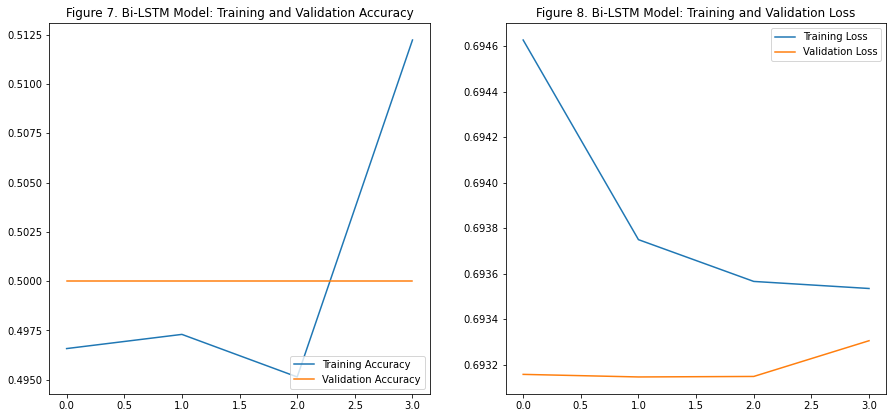

In [49]:
# plot the graph of accuracy
acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

epochs_range = range(4)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc2, label='Training Accuracy')
plt.plot(epochs_range, val_acc2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Figure 7. Bi-LSTM Model: Training and Validation Accuracy')

# plot the graph of loss
plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss2, label='Training Loss')
plt.plot(epochs_range, val_loss2, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Figure 8. Bi-LSTM Model: Training and Validation Loss')
plt.show()

### 4.3 Gated Recurrent Unit (GRU)

A Gated Recurrent Unit, or GRU, is a type of recurrent neural network. It is similar to an LSTM, but only has two gates — a reset gate and an update gate and notably lacks an output gate. Fewer parameters means GRUs are generally easier/faster to train than their LSTM counterparts.

In [50]:
# define GRU model
model3 = Sequential()
model3.add(Embedding(vocab_size,
                     embedding_dim,
                     input_length = max_len))
model3.add(SpatialDropout1D(0.2))
model3.add(GRU(128, return_sequences = False))
model3.add(Dropout(0.2))
model3.add(Dense(1, activation = 'sigmoid'))

# summary model3
model3.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 18980, 128)        2434176   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 18980, 128)        0         
_________________________________________________________________
gru (GRU)                    (None, 128)               99072     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 2,533,377
Trainable params: 2,533,377
Non-trainable params: 0
_________________________________________________________________


In [51]:
# compile model3
model3.compile(loss = 'binary_crossentropy',
                       optimizer = 'adam',
                       metrics=['accuracy', tf.keras.metrics.AUC()])


In [52]:
# train model3
num_epochs = 10
early_stop = EarlyStopping(monitor='val_loss', patience=2)
mp = ModelCheckpoint(filepath='model3_cp', monitor='val_loss', save_best_only=True)
history3 = model3.fit(x_train,
                     y_train,
                     epochs=num_epochs, 
                     validation_data=(x_valid, y_valid),
                     callbacks =[early_stop, mp],
                     verbose=2)

Epoch 1/10
174/174 - 134s - loss: 0.6947 - accuracy: 0.5013 - auc_2: 0.5011 - val_loss: 0.6943 - val_accuracy: 0.5000 - val_auc_2: 0.5010
Epoch 2/10
174/174 - 132s - loss: 0.6942 - accuracy: 0.5014 - auc_2: 0.4944 - val_loss: 0.6935 - val_accuracy: 0.5000 - val_auc_2: 0.5000
Epoch 3/10
174/174 - 132s - loss: 0.6942 - accuracy: 0.4989 - auc_2: 0.4953 - val_loss: 0.6932 - val_accuracy: 0.5000 - val_auc_2: 0.5000
Epoch 4/10
174/174 - 132s - loss: 0.6934 - accuracy: 0.5036 - auc_2: 0.5048 - val_loss: 0.6940 - val_accuracy: 0.5000 - val_auc_2: 0.5000
Epoch 5/10
174/174 - 132s - loss: 0.6939 - accuracy: 0.4923 - auc_2: 0.4925 - val_loss: 0.6932 - val_accuracy: 0.5000 - val_auc_2: 0.5000


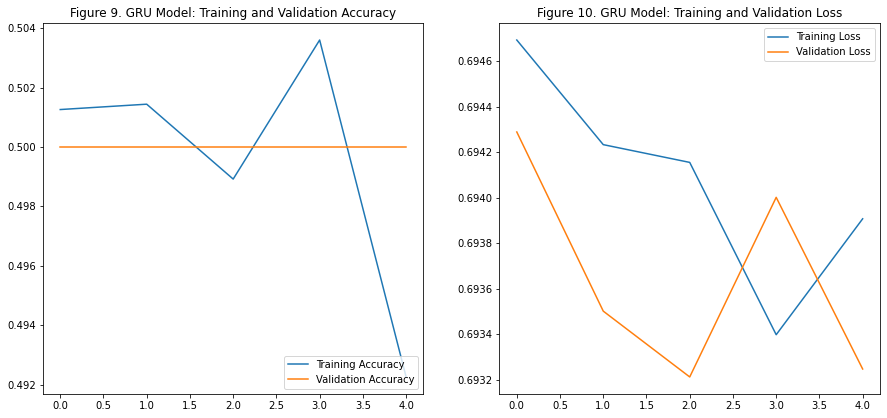

In [54]:
# plot the graph of accuracy
acc3 = history3.history['accuracy']
val_acc3 = history3.history['val_accuracy']
loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc3, label='Training Accuracy')
plt.plot(epochs_range, val_acc3, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Figure 9. GRU Model: Training and Validation Accuracy')

# plot the graph of loss
plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss3, label='Training Loss')
plt.plot(epochs_range, val_loss3, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Figure 10. GRU Model: Training and Validation Loss')
plt.show()


## Step 4: Results and Analysis

### 4.1 Results

#### Model 1

In [57]:
score = model1.evaluate(x_valid, y_valid)

31/31 [==============================] - 12s 382ms/step - loss: 0.6934 - accuracy: 0.5000 - auc: 0.5000


In [58]:
print('LSTM model loss:', score[0])
print('LSTM model accuracy:', score[1])

LSTM model loss: 0.6933974623680115
LSTM model accuracy: 0.5


In [59]:
# add validation accuracy score into list
v_auc_score1 = history.history["val_auc"]
valid_auc_score.append(v_auc_score1)

# best validation accuracy result
best_val_auc1 = max(v_auc_score1)
print("LSTM Best Validation AUC: ", best_val_auc1)


LSTM Best Validation AUC:  0.5010183453559875


In [61]:
# make predictions on the validation dataset
#load_model1 = keras.models.load_model('model1_cp')
y_pred1 = model1.predict(x_valid)
y_pred1 = np.where(y_pred1>0.5, 1, 0)

# print out classification report
print(classification_report(y_valid, y_pred1))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       491
           1       0.50      1.00      0.67       491

    accuracy                           0.50       982
   macro avg       0.25      0.50      0.33       982
weighted avg       0.25      0.50      0.33       982



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

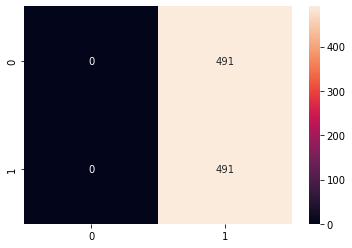

In [62]:
# print out the confusion matrix
cm1 = confusion_matrix(y_valid, y_pred1)
sns.heatmap(cm1, annot=True, fmt=".0f")


#### Model 2

In [63]:
score2 = model2.evaluate(x_valid, y_valid)
print('Bi-LSTM model loss:', score2[0])
print('Bi-LSTM model accuracy:', score2[1])


31/31 [==============================] - 24s 776ms/step - loss: 0.6933 - accuracy: 0.5000 - auc_1: 0.5000
Bi-LSTM model loss: 0.6933056712150574
Bi-LSTM model accuracy: 0.5


In [69]:
# add validation accuracy score into list
v_auc_score2 = history2.history["val_auc_1"]
#v_auc_score2 = history2.history["val_auc"]
valid_auc_score.append(v_auc_score2)

# best validation accuracy result
best_val_auc2 = max(v_auc_score2)
print("Bi_LSTM Best Validation AUC: ", best_val_auc2)


Bi_LSTM Best Validation AUC:  0.5


In [65]:
# make predictions on the validation dataset
#load_model2 = keras.models.load_model('model2_cp')
y_pred2 = model2.predict(x_valid)
y_pred2 = np.where(y_pred2>0.5, 1, 0)

# print out classification report
print(classification_report(y_valid, y_pred2))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       491
           1       0.50      1.00      0.67       491

    accuracy                           0.50       982
   macro avg       0.25      0.50      0.33       982
weighted avg       0.25      0.50      0.33       982



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

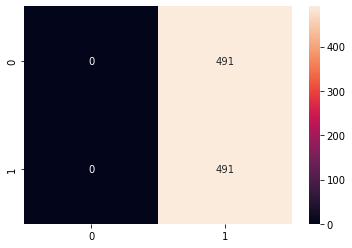

In [80]:
# print out the confusion matrix
cm2 = confusion_matrix(y_valid, y_pred2)
sns.heatmap(cm2, annot=True, fmt=".0f")


#### Model 3

In [67]:
score3 = model3.evaluate(x_valid, y_valid)
print('GRU model loss:', score3[0])
print('GRU model accuracy:', score3[1])


31/31 [==============================] - 9s 275ms/step - loss: 0.6932 - accuracy: 0.5000 - auc_2: 0.5000
GRU model loss: 0.69324791431427
GRU model accuracy: 0.5


In [70]:
# add validation accuracy score into list
v_auc_score3 = history3.history["val_auc_2"]
valid_auc_score.append(v_auc_score3)

# best validation accuracy result
best_val_auc3 = max(v_auc_score3)
print("GRU Best Validation AUC: ", best_val_auc3)


GRU Best Validation AUC:  0.5010183453559875


In [71]:
# make predictions on the validation dataset
#load_model3 = keras.models.load_model('model3_cp')
y_pred3 = model3.predict(x_valid)
y_pred3 = np.where(y_pred3>0.5, 1, 0)

# print out classification report
print(classification_report(y_valid, y_pred3))


              precision    recall  f1-score   support

           0       0.50      1.00      0.67       491
           1       0.00      0.00      0.00       491

    accuracy                           0.50       982
   macro avg       0.25      0.50      0.33       982
weighted avg       0.25      0.50      0.33       982



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

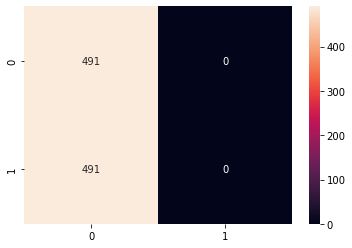

In [72]:
# print out the confusion matrix
cm3 = confusion_matrix(y_valid, y_pred3)
sns.heatmap(cm3, annot=True, fmt=".0f")


### 4.2 Comparing the three different models


In [75]:
# create compare dataframe to compare three models
models = {'Model': ["LSTM", "Bi_LSTM", "GRU"],
        'Accuracy': [score[1], score2[1], score3[1]],
        'Loss': [score[0], score2[0], score3[0]],
         'Best Validation AUC': [best_val_auc1, best_val_auc2, best_val_auc3]}
compare_data = pd.DataFrame(models)
compare_data = compare_data.sort_values(by='Best Validation AUC', ascending = False, ignore_index=True)
print("Compare three deep learning models: ")
display(compare_data)


Compare three deep learning models: 


,Model,Accuracy,Loss,Best Validation AUC
0,LSTM,0.5,0.693397,0.501018
1,GRU,0.5,0.693248,0.501018
2,Bi_LSTM,0.5,0.693306,0.500000


We observe that LSTM and GRU models are better than Bi-LSTM model with higher best validation AUC.

### 4.3 Run Dropout Tuning 

Dropout is a technique where randomly selected neurons are ignored during training. This means that their contribution to the activation of downstream neurons is temporally removed on the forward pass, and any weight updates are not applied to the neuron on the backward pass.

When we have training data, if we try to train your model too much, it might overfit, and dropout regularization is one technique used to tackle overfitting problems in deep learning.  

In this project, we will use LSTM model and try 3 different Dropout: [0.1, 0.2, 0.3].  

Because we are creating many models in a loop, this global state will consume an increasing amount of memory over time, so we should clear it. Calling clear_session() releases the global state: this helps avoid clutter from old models and layers, especially when memory is limited.  

In [79]:
# create a list to store the result
dropout_val_auc = []

for dropout in [0.1, 0.2, 0.3]:
    #  clear session:\
    tf.keras.backend.clear_session()
    
    # define new model
    new_model = Sequential()
    new_model.add(Embedding(vocab_size,
                     embedding_dim,
                     input_length = max_len))
    new_model.add(LSTM(n_lstm, return_sequences=False))
    new_model.add(Dropout(dropout))
    new_model.add(Dense(1, activation='sigmoid'))

    # compile new model
    new_model.compile(loss = 'binary_crossentropy',
                        optimizer = 'adam',
                        metrics=['accuracy', tf.keras.metrics.AUC()])

    # train new model
    num_epochs = 10
    new_history = new_model.fit(x_train,
                         y_train,
                         epochs=num_epochs, 
                         validation_data=(x_valid, y_valid),
                         verbose=2)
    # best result
    print("Best Validation AUC for Dropout: ", dropout, "is: ", max(new_history.history["val_auc"]))

    # add validation AUC score into list
    dropout_val_auc.append(new_history.history["val_auc"])

Epoch 1/10
174/174 - 198s - loss: 0.6943 - accuracy: 0.4924 - auc: 0.4891 - val_loss: 0.6932 - val_accuracy: 0.5000 - val_auc: 0.5000
Epoch 2/10
174/174 - 195s - loss: 0.6935 - accuracy: 0.4926 - auc: 0.4934 - val_loss: 0.6934 - val_accuracy: 0.5000 - val_auc: 0.5000
Epoch 3/10
174/174 - 195s - loss: 0.6936 - accuracy: 0.4946 - auc: 0.4933 - val_loss: 0.6932 - val_accuracy: 0.5000 - val_auc: 0.5031
Epoch 4/10
174/174 - 195s - loss: 0.6934 - accuracy: 0.4878 - auc: 0.4917 - val_loss: 0.6931 - val_accuracy: 0.5000 - val_auc: 0.5000
Epoch 5/10
174/174 - 196s - loss: 0.6934 - accuracy: 0.4944 - auc: 0.4932 - val_loss: 0.6931 - val_accuracy: 0.5000 - val_auc: 0.5010
Epoch 6/10
174/174 - 195s - loss: 0.6935 - accuracy: 0.4844 - auc: 0.4811 - val_loss: 0.6932 - val_accuracy: 0.5000 - val_auc: 0.5000
Epoch 7/10
174/174 - 195s - loss: 0.6935 - accuracy: 0.4942 - auc: 0.4960 - val_loss: 0.6932 - val_accuracy: 0.5000 - val_auc: 0.5000
Epoch 8/10
174/174 - 195s - loss: 0.6933 - accuracy: 0.4995 - 

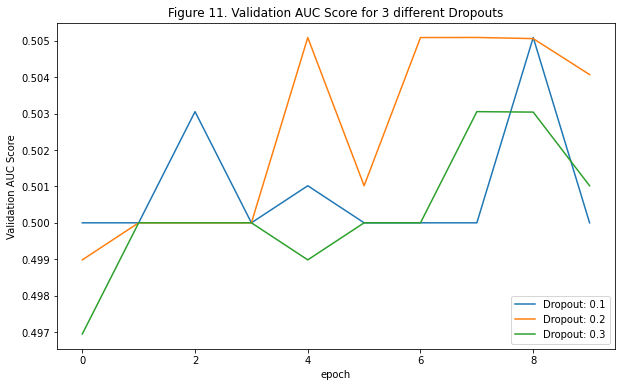

In [81]:
# plot validation AUC score for three different droupouts
plt.figure(figsize=(10, 6))
plt.xlabel("epoch")
plt.ylabel("Validation AUC Score")
epoch_range = list(range(10))
labels = ["Dropout: 0.1", "Dropout: 0.2", "Dropout: 0.3"]
for i in range(len(dropout_val_auc)):
    plt.plot(epoch_range, dropout_val_auc[i], label=f'{labels[i]}')
plt.legend(loc='lower right')
plt.title("Figure 11. Validation AUC Score for 3 different Dropouts")
plt.show()


Looking at the result above, we can conclude that in this case, the best dropout is 0.2

### 4.3 Use the best model to predict test data without target

Looking at the compare dataframe above, we can see that GRU is the best model because it has the highest validation AUC score and least loss compare to LSTM and Bi-LSTM models and the best droupout is 0.2. That is the model 3 (GRU) was built above, so now I will: 
+ clean text in test data
+ vectorizing text
+ use model 3 for predicting test data
+ create submission file

In [82]:
# clean test data
clean_text(test, "text")

# view text in a row after cleaning all text data
test["text"][0]


'happened terrible car crash'

In [95]:
# create vector for test set
test_vectors = count_vectorizer.fit_transform(test["text"])


In [85]:
# load model3
best_model = tf.keras.models.load_model('model3_cp')

In [97]:
# predict test data
test_vectors = test_vectors.toarray()
y_pred = best_model.predict(test_vectors)
test_predictions = np.where(y_pred>0.5, 1, 0)

In [98]:
# create dataframe of result
submission = pd.DataFrame()
submission['id'] = test['id']
submission['target'] = test_predictions
submission.head()


,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [99]:
# view test prediction counts
submission['target'].value_counts()


1    3249
0      14
Name: target, dtype: int64

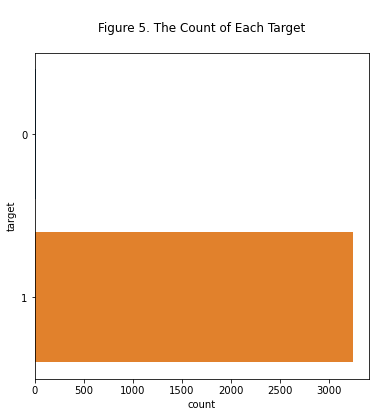

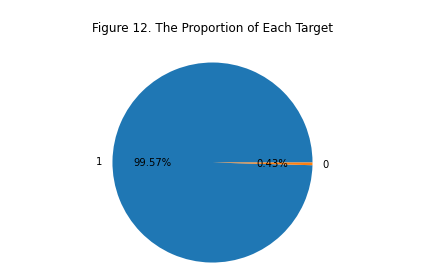

In [100]:
# plot the count of each label
fig, ax = plt.subplots(figsize=(6,6))
sns.countplot(data=submission, y='target', ax=ax).set(title='\nFigure 5. The Count of Each Target\n')

# plot the proportion of each label
labels = submission['target'].unique().tolist()
counts = submission['target'].value_counts()
sizes = [counts[v] for v in labels]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%0.2f%%')
ax1.axis('equal')
plt.title("\nFigure 12. The Proportion of Each Target\n")
plt.tight_layout()
plt.show()


In [101]:
# convert to csv to submit to competition
submission.to_csv('submission.csv', index=False)


## Step 5: Conclusion

In this project, there are 5 parts:  

(1) Brief description of the problem and data.     
(2) EDA - Inspect, Visualize, and Clean the data.    
(3) Building and training models:   
+ LSTM 
+ Bi-LSTM  
+ GRU    
 
(4) Results and Analysis.  
(5) Conclusion.     

The goal of this project is to detect fake and real disaster tweets. By comparing three different deep learning models including: LSTM, Bi-LSTM and GRU, we can conclude that in this case, the GRU model is the model that has the best performance with the highest validation AUC value of 0.501018 and the loss value = 0.693248. I know this result was not good, however, because of the limitation of data and the running time was too costly, the models just were trained on limited approach. I think there are many other ways can improve this kind of project such as: building more deep learning models by tuning hyperparameters to get optimal results, or we can run models with more epoch, or use other type of Word Embeddings such as: Tokenization or Bag-of-Words. 


Because of the curiosity, I would like to print out the predictions of all three models and let's see how these model's performance are.

In [ ]:
# use three models predict test set and print out the submission 

for m in ["model1", "model2", "model3"]:
    model = tf.keras.models.load_model(f'{m}_cp')
    
    # predict test data
    y_pred = model.predict(test_vectors)
    test_predictions = np.where(y_pred > 0.5, 1, 0)
    
    # create dataframe of result
    submission = pd.DataFrame()
    submission['id'] = test['id']
    submission['target'] = test_predictions
    submission.to_csv(f'{m}_submission.csv', index=False)

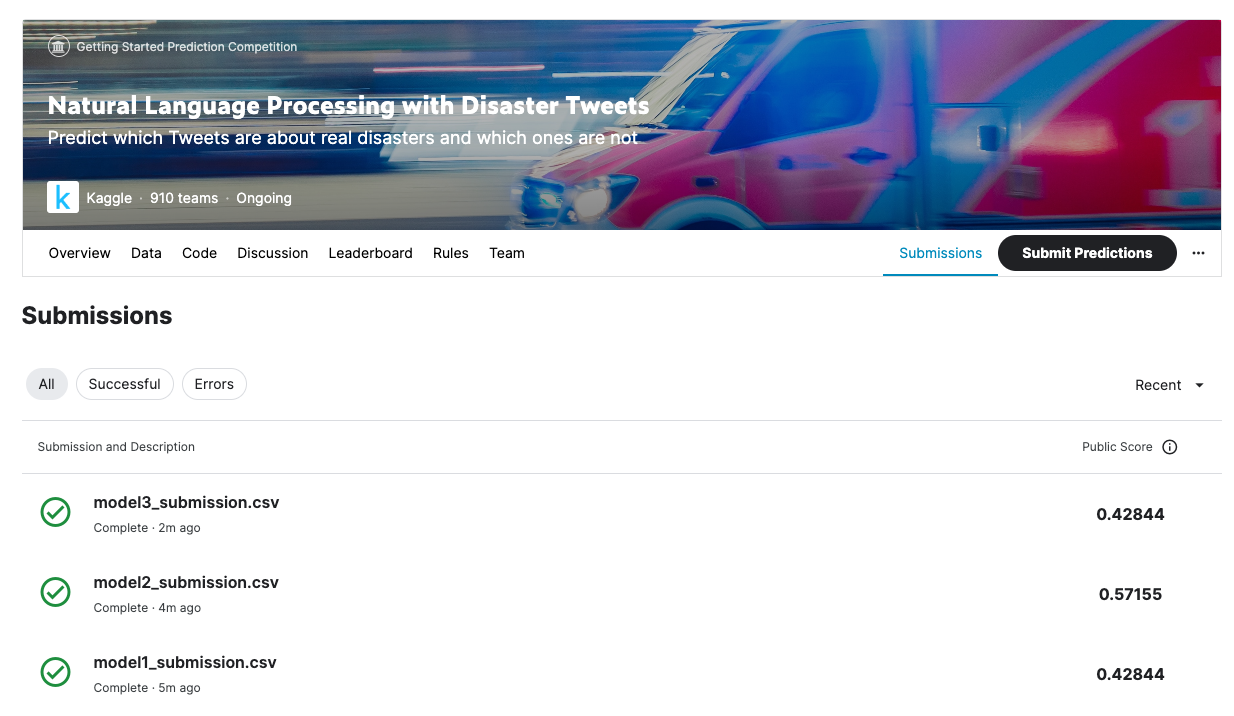

It's interesting that model 2 (Bi-LSTM) has better score.